# Libraries and Global Variables

In [ ]:
!pip install -q 'tensorflow-text==2.11.*'
!pip install -q tensorflow_datasets
!pip install -q einops

ERROR: Could not find a version that satisfies the requirement tensorflow-text==2.11.* (from versions: 2.12.0rc0, 2.12.0, 2.12.1, 2.13.0rc0, 2.14.0rc0, 2.14.0, 2.15.0rc0, 2.15.0, 2.16.0rc0, 2.16.1, 2.17.0rc0, 2.17.0, 2.18.0rc0, 2.18.0, 2.18.1)
ERROR: No matching distribution found for tensorflow-text==2.11.*


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import collections
import time
import string
import re
import einops
from tqdm.auto import tqdm
from PIL import Image
import nltk
from nltk.util import ngrams

import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_datasets as tfds

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Downloading Dataset

In [ ]:
def get_data(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

def get_dataset(path = 'flickr8k'):

    path = pathlib.Path('flickr8k')
    captions = (path/'Flickr8k_text.zip/Flickr8k.token.txt').read_text().splitlines()
    captions = [cap.split('\t') for cap in captions]
    captions = [(img_path.split('#')[0], cap) for (img_path, cap) in captions]
    cap_dict = collections.defaultdict(list)
    for img_path, cap in captions:
        cap_dict[img_path].append(cap)

    train_imgs_path = (path/'Flickr8k_text.zip/Flickr_8k.trainImages.txt').read_text().splitlines()
    test_imgs_path = (path/'Flickr8k_text.zip/Flickr_8k.testImages.txt').read_text().splitlines()

    train_caps = [(str(path/'Flickr8k_Dataset.zip/Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in train_imgs_path]
    test_caps = [(str(path/'Flickr8k_Dataset.zip/Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in test_imgs_path]

    train_raw = tf.data.experimental.from_list(train_caps)
    test_raw = tf.data.experimental.from_list(test_caps)

    return train_raw, test_raw

folder_path = "/content/flickr8k"

In [ ]:
get_data()
train_raw, test_raw = get_dataset()

1115419746/1115419746 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step
2340801/2340801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(len(train_raw), len(test_raw))
print(train_raw.element_spec)

for img_path, captions in train_raw.take(1):
    break

print(img_path)
print(captions)

6000 1000
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.string, name=None))
tf.Tensor(b'flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


# Data Preprocessing

## Image Feature Extractor

In [ ]:
image_shape = (224, 224, 3)
feature_extractor = tf.keras.applications.MobileNetV3Small(input_shape = image_shape, include_preprocessing = True, include_top = False)
feature_extractor.trainable = False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, image_shape[:-1])
    return img

In [ ]:
img = load_img(img_path.numpy().decode('utf-8'))
print(img.shape)
print(feature_extractor(img[tf.newaxis, ...]).shape)

(224, 224, 3)
(1, 7, 7, 576)


## Text Standardizer

In [ ]:
def standardize(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, f'[{re.escape(string.punctuation)}]', '')
    text = tf.strings.join(['[START]',text,'[END]'], separator = ' ')
    return text

In [ ]:
standardize('A black dog is running after a white dog in the snow .')

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] a black dog is running after a white dog in the snow  [END]'>

## Text Vectorizer

In [ ]:
vocab_size = 5000
vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                               standardize = standardize,
                                               ragged = True)

vectorizer.adapt(train_raw.map(lambda img_path, cap: cap).unbatch().batch(1024))

In [ ]:
print(vectorizer.get_vocabulary()[:10])

['', '[UNK]', np.str_('a'), np.str_('[START]'), np.str_('[END]'), np.str_('in'), np.str_('the'), np.str_('on'), np.str_('is'), np.str_('and')]


In [ ]:
text_to_id_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '')
id_to_text_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '', invert = True)

## Serialization

In [ ]:
def id_to_text(token_ids, reserved_tokens = ['', '[UNK]', '[START]', '[END]']):
    words = id_to_text_vectorizer(token_ids)
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != '[UNK]']
    bad_tokens_re = '|'.join(bad_tokens)
    bad_mask = tf.strings.regex_full_match(words, bad_tokens_re)
    words = tf.ragged.boolean_mask(words, ~bad_mask)

    return tf.strings.reduce_join(words, axis = -1, separator = ' ')

def serialize_data(images, captions):
    captions_shape = einops.parse_shape(captions, 'b c')
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(images, 'b ...  -> (b c) ...', c = captions_shape['c'])
    return images, captions

In [ ]:
for img, cap in train_raw.batch(1024).take(1):
    break

print(img.shape)
print(cap.shape)
img_serialize, cap_serialize = serialize_data(img, cap)
print(img_serialize.shape, cap_serialize.shape)

(1024,)
(1024, 5)
(5120,) (5120,)


## Splitting Data into Batches/Shards

In [ ]:
def prepare_batch(img, cap):
    cap_tokenized = vectorizer(cap)
    cap_tokenized_in = cap_tokenized[:, :-1]
    cap_tokenized_out = cap_tokenized[:, 1:]

    return (img, cap_tokenized_in.to_tensor()), cap_tokenized_out.to_tensor()

In [ ]:
def save_dataset(raw_ds, file_path, image_feature_extractor, vectorizer, shards = 20, batch_size = 64):
    raw_ds = (raw_ds
              .map(lambda img_path, cap: (load_img(img_path), cap), tf.data.AUTOTUNE)
              .batch(batch_size))

    def gen():
        for (img, cap) in tqdm(raw_ds):
            img_features = image_feature_extractor(img)
            img_features, cap = serialize_data(img_features, cap)

            yield img_features, cap

    ds = tf.data.Dataset.from_generator(gen,
                                        output_signature = (
                                            tf.TensorSpec(shape = image_feature_extractor.output_shape),
                                            tf.TensorSpec(shape = (None,), dtype = tf.string)
                                        ))

    ds = (ds
          .map(prepare_batch, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(1000))

    def shard_func(i, data):
        return i % shards

    ds.enumerate().save(file_path, shard_func = shard_func)

In [ ]:
%%time
save_dataset(train_raw, 'train_cache', feature_extractor, vectorizer)
save_dataset(test_raw, 'test_cache', feature_extractor, vectorizer)

  0%|          | 0/94 [00:03<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 1min 1s, sys: 13.7 s, total: 1min 14s
Wall time: 1min 34s


In [ ]:
def load_dataset(file_path, batch_size = 64, cycle_length = 2):
    def reader_func(ds):
        ds = ds.shuffle(1000)
        return ds.interleave(lambda x: x, cycle_length = cycle_length)

    def drop_index(i, x):
        return x

    ds = tf.data.Dataset.load(file_path, reader_func = reader_func)

    ds = (ds
          .map(drop_index)
          .shuffle(1000)
          .padded_batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))
    return ds

In [ ]:
batch_size = 64
train_ds = load_dataset('train_cache', batch_size)
test_ds = load_dataset('test_cache', batch_size)

In [ ]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

print(cap[0])
print(cap_labels[0])

(64, 7, 7, 576)
(64, 37)
(64, 37)
tf.Tensor(
[  3  12  11 157 280   2 159  36 994   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0], shape=(37,), dtype=int64)
tf.Tensor(
[ 12  11 157 280   2 159  36 994   4   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0], shape=(37,), dtype=int64)


In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

# Text Positional Encoding

In [ ]:
def positional_encoding(length, depth):
    pos = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)
    dep = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)
    dep = ((dep // 2)*2)/tf.cast(depth, tf.float32)

    angle_rates = 1 / (10000**dep)
    angle_rads = pos*angle_rates

    out = tf.Variable(tf.zeros((length, depth)))
    out[:, 0::2].assign(tf.math.sin(angle_rads[:, 0::2]))
    out[:, 1::2].assign(tf.math.cos(angle_rads[:, 1::2]))

    return out[tf.newaxis, ...]

In [ ]:
sample_enc = positional_encoding(length = 2048, depth = 512)[0]

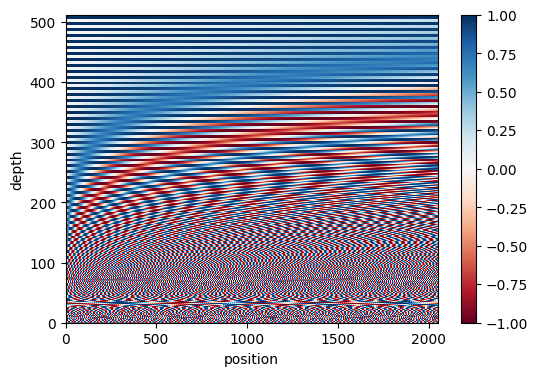

In [ ]:
plt.figure(figsize = (6, 4))
plt.pcolormesh(tf.transpose(sample_enc), cmap = 'RdBu')
plt.xlabel('position')
plt.ylabel('depth')
plt.colorbar()
plt.show();

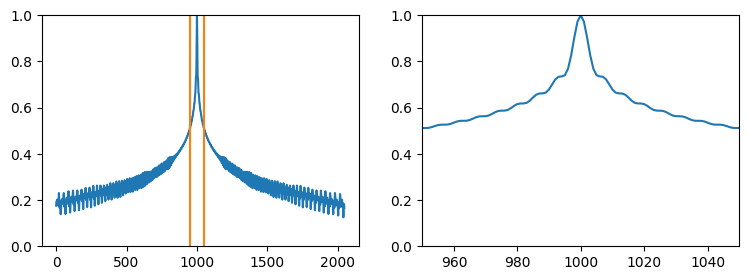

In [ ]:
p_norm = tf.linalg.l2_normalize(sample_enc[1000][tf.newaxis, :])
sample_enc_norm = tf.linalg.l2_normalize(sample_enc, axis = 1)
dots = tf.linalg.matmul(sample_enc_norm, p_norm, transpose_b = True)

plt.figure(figsize = (9, 3))
plt.subplot(1, 2, 1)
plt.plot(dots)
plt.ylim([0, 1])
plt.plot([950, 950, float('nan'), 1050, 1050], [0, 1, float('nan'), 0, 1])

plt.subplot(1, 2, 2)
plt.plot(dots)
plt.ylim([0, 1])
plt.xlim([950, 1050])
plt.show()

# Building Model

## Positional Embedding

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero = True)
        self.pos_enc = positional_encoding(length = 2048, depth = d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x_emb = self.embedding(x)
        x_pos_enc = self.pos_enc[:, :length, :]

        x_emb *= tf.cast(self.d_model, tf.float32)
        x_emb += x_pos_enc

        return x_emb

In [ ]:
sample_pos_emb = PositionalEmbedding(vocab_size, d_model = 512)
cap_emb = sample_pos_emb(cap)
print(cap_emb.shape)

(64, 37, 512)


## Base Attention Layer

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

## Causal Attention Layer

In [ ]:
class CausalAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query = x,
                               key = x,
                               value = x,
                               use_causal_mask = True)

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
sample_csa = CausalAttention(num_heads = 8, key_dim = 512)
sample_csa_out = sample_csa(cap_emb)
print(sample_csa_out.shape)

(64, 37, 512)


## Cross Attention Layer

In [ ]:
class CrossAttention(BaseAttention):
    def call(self, context, x):
        attn_out, attn_scores = self.mha(query = x,
                                         key = context,
                                         value = context,
                                         return_attention_scores = True)

        self.last_attention_scores = attn_scores

        x = self.add([x, attn_out])
        x = self.layernorm(x)
        return x

In [ ]:
img_ = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img.shape, img_.shape)

sample_ca = CrossAttention(num_heads = 8, key_dim = 512)
sample_ca_out = sample_ca(context = img_, x = sample_csa_out)
print(sample_ca_out.shape)

(64, 7, 7, 576) (64, 49, 576)
(64, 37, 512)


## Feed Forward Mechanism

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation = 'relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(rate = dropout_rate)
        ])

        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        return x

In [ ]:
sample_ffn = FeedForward(d_model = 512, dff = 2048)
sample_ffn_out = sample_ffn(sample_ca_out)
print(sample_ffn_out.shape)

(64, 37, 512)


## Decoder Layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate = 0.1):
        super().__init__()
        self.causal_attention = CausalAttention(num_heads = num_heads,
                                                key_dim = d_model,
                                                dropout = dropout_rate)
        self.cross_attention = CrossAttention(num_heads = num_heads,
                                              key_dim = d_model,
                                              dropout = dropout_rate)
        self.ffn = FeedForward(d_model = d_model,
                               dff = dff,
                               dropout_rate = dropout_rate)
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.causal_attention(x)
        x = self.cross_attention(context = context, x = x)
        x = self.ffn(x)
        self.last_attention_scores = self.cross_attention.last_attention_scores

        return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model = 512, dff = 2048, num_heads = 8, dropout_rate = 0.2)
sample_decoder_layer_out = sample_decoder_layer(context = img_, x = cap_emb)
print(sample_decoder_layer_out.shape)

(64, 37, 512)


## Output Layer

In [ ]:
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, vocab, bad_tokens = ('', '[UNK]', '[START]')):
        super().__init__()
        self.vocab = vocab
        self.bad_tokens = bad_tokens
        self.bias = 0
        self.dense_layer = tf.keras.layers.Dense(len(vocab), activation = tf.nn.log_softmax)

    def adapt(self, cap_ds):
        word_idx = {word : idx for idx, word in enumerate(self.vocab)}
        counts = collections.Counter()
        for tokens in cap_ds:
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros((len(self.vocab), ))
        for token_id, cnt in counts.items():
            counts_arr[token_id] = cnt

        bad_indices = np.array([word_idx[word] for word in self.bad_tokens])
        counts_arr[bad_indices] = 0

        counts_prob = counts_arr / counts_arr.sum()
        counts_prob[counts_arr == 0] = 1
        log_p = np.log(counts_prob)

        entropy = (-counts_prob*log_p).sum()

        print(f'uniform_entropy : {np.log(len(self.vocab))}')
        print(f'curr_entropy : {entropy}')
        log_p[counts_arr == 0] = -1e9

        self.bias = log_p[tf.newaxis, tf.newaxis, :]

    def call(self, x):
        return self.dense_layer(x) + self.bias

In [ ]:
vocab = vectorizer.get_vocabulary()
sample_output_layer = OutputLayer(vocab)
sample_output_layer.adapt(train_ds.map(lambda img, cap: cap))
sample_output_layer_out = sample_output_layer(sample_decoder_layer_out)
print(sample_output_layer_out.shape)

uniform_entropy : 8.517193191416238
curr_entropy : 5.292547935444457
(64, 37, 5000)


## Transformer - Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.num_layers = num_layers

        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.decoder_layers = [DecoderLayer(d_model, dff, num_heads, dropout_rate) for _ in range(num_layers)]
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.positional_embedding(x)
        for i in range(self.num_layers):
            x = self.decoder_layers[i](context = context, x = x)

        self.last_attention_scores = self.decoder_layers[-1].last_attention_scores
        return x

In [ ]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

img_features = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img_features.shape)

(64, 7, 7, 576)
(64, 37)
(64, 37)
(64, 49, 576)


In [ ]:
%%time
sample_decoder = Decoder(num_layers = 6, num_heads = 8, d_model = 512, dff = 2048)
sample_decoder_output = sample_decoder(context = img_features, x = cap)
print(sample_decoder_output.shape)
print(sample_decoder.last_attention_scores.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_2' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 37, 512)
(64, 8, 37, 49)
CPU times: user 4.06 s, sys: 115 ms, total: 4.17 s
Wall time: 4.33 s


## Captioning Model

In [ ]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, vectorizer, feature_extractor, output_layer, num_layers, num_heads, d_model, dff, pred_max_len =  50, dropout_rate = 0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.vectorizer = vectorizer
        self.output_layer = output_layer
        self.decoder = Decoder(num_layers, num_heads, d_model, dff, dropout_rate)
        self.max_len = pred_max_len
        self.vocab = self.vectorizer.get_vocabulary()

    def call(self, inputs):
        context, cap = inputs
        if context.shape[-1] == 3:
            context = self.feature_extractor(context)
        context = einops.rearrange(context, 'b h w c -> b (h w) c')

        if cap.dtype == tf.string:
            cap = self.vectorizer([cap])


        x = self.decoder(context = context, x = cap)
        x = self.output_layer(x)
        return x

In [ ]:
%%time
sample_captioner = Captioner(vectorizer = vectorizer,
                             feature_extractor = feature_extractor,
                             output_layer = sample_output_layer,
                             num_layers = 6,
                             num_heads = 8,
                             d_model = 512,
                             dff = 2048,
                             dropout_rate = 0.2)

print(sample_captioner((img, cap)).shape)
print(cap_labels.shape)
print(sample_captioner.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_8' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 37, 5000)
(64, 37)


Model: "captioner"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (OutputLayer)           │ ?                           │       2,565,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Decoder)                  │ ?                           │     119,139,328 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,643,448 (467.85 MB)

 Trainable params: 121,704,328 (464.27 MB)

 Non-trainable params: 939,120 (3.58 MB)

None
CPU times: user 5.06 s, sys: 450 ms, total: 5.51 s
Wall time: 5.7 s


In [ ]:
d_model = 128
dff = 128
dropout_rate = 0.4
num_layers = 2
num_heads = 2
output_layer = OutputLayer(vocab)
output_layer.adapt(train_ds.map(lambda img_feature, cap: cap))

uniform_entropy : 8.517193191416238
curr_entropy : 5.292547935444457


In [ ]:
for (img_feature, cap), cap_labels in train_ds.take(1):
    break
print(img_feature.shape)
print(cap.shape)
print(cap_labels.shape)

(64, 7, 7, 576)
(64, 37)
(64, 37)


In [ ]:
%%time
captioner_model = Captioner(vectorizer = vectorizer,
                            feature_extractor = feature_extractor,
                            output_layer = output_layer,
                            num_layers = num_layers,
                            num_heads = num_heads,
                            d_model = d_model,
                            dff = dff,
                            dropout_rate = dropout_rate)

print(captioner_model((img_feature, cap), training = False).shape)
captioner_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_14' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 37, 5000)


Model: "captioner_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer_1 (OutputLayer)         │ ?                           │         645,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_2 (Decoder)                  │ ?                           │       1,694,208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,278,328 (12.51 MB)

 Trainable params: 2,339,208 (8.92 MB)

 Non-trainable params: 939,120 (3.58 MB)

CPU times: user 1.61 s, sys: 167 ms, total: 1.78 s
Wall time: 1.77 s


In [ ]:
@Captioner.add_method
def generate_text(self, img, temperature = 0.5):
    if img.shape[-1] == 3:
        img = self.feature_extractor(img)
    start_token = text_to_id_vectorizer([['[START]']])

    start_idx = self.vocab.index('[START]')
    end_idx = self.vocab.index('[END]')

    for i in range(self.max_len):
        preds = self((img, start_token))
        preds = preds[:, -1, :]
        if temperature == 0.0:
            pred_idx = tf.argmax(preds, axis = -1)[:, tf.newaxis]
        else:
            preds /= temperature
            pred_idx = tf.random.categorical(preds, num_samples = 1)

        start_token = tf.concat([start_token, pred_idx], axis = -1)

        if pred_idx[0][0] == end_idx:
            break

    return id_to_text(start_token).numpy()[0].decode('utf-8')

## Defining Metrics

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def brevity_penalty(can, ref):
    can_tokens = nltk.word_tokenize(can)
    ref_tokens = nltk.word_tokenize(ref)
    if len(can_tokens) == 0:
        return 0.0
    return min(1, np.exp(1 - (len(ref_tokens) / len(can_tokens))))

def precision(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(can_n.values())

    if total == 0:
        return 0

    for n_g in can_n:
        if n_g in ref_n:
            can_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            can_n[n_g] = 0
    return sum(can_n.values()) / total

def bleu_score(can , ref, n_gram_range = 2):
    precisions = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        precisions.append(precision(can, ref, n))
    precisions = np.array(precisions)

    if 0 in precisions:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(precisions).mean())

def recall(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(ref_n.values())

    if total == 0:
        return 0

    for n_g in ref_n:
        if n_g in can_n:
            ref_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            ref_n[n_g] = 0
    return sum(ref_n.values()) / total

def rouge_score(can , ref, n_gram_range = 2):
    recalls = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        recalls.append(recall(can, ref, n))
    recalls = np.array(recalls)

    if 0 in recalls:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(recalls).mean())

def bleu_1(can, ref):
    return corpus_bleu(ref, can, weights=(1.0, 0, 0, 0))
    # return bleu_score(can, ref, n_gram_range=1)

def bleu_2(can, ref):
    return corpus_bleu(ref, can, weights=(0.5, 0.5, 0, 0))

def bleu_3(can, ref):
    return corpus_bleu(ref, can, weights=(0.33, 0.33, 0.33, 0))

def bleu_4(can, ref):
    return corpus_bleu(ref, can, weights=(0.25, 0.25, 0.25, 0.25))

from nltk.translate.meteor_score import meteor_score

def meteor(can, refs):
    return max(meteor_score([ref], can) for ref in refs)

In [ ]:
@Captioner.add_method
def f_score(self, can, refs, n_gram_range = 1):
    b_scores = [bleu_score(can, ref, n_gram_range) for ref in refs]
    r_scores = [rouge_score(can, ref, n_gram_range)  for ref in refs]
    f_vals = []
    for b_score, r_score in zip(b_scores, r_scores):
        if b_score + r_score == 0:
            return 0
        f_vals.append((2*b_score*r_score) / (b_score + r_score))

    return max(f_vals)

In [ ]:
def masked_loss(labels, preds):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
    loss = tf.cast(loss_fn(labels, preds), tf.float32)
    mask = ((labels != 0) & (loss < 1e8))
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)

def masked_accuracy(labels, preds):
    preds = tf.cast(tf.argmax(preds, axis = -1), tf.float32)
    labels = tf.cast(labels, tf.float32)
    mask = tf.cast(labels != 0, tf.float32)
    acc = tf.cast(preds == labels, tf.float32)
    acc *= mask
    return tf.math.reduce_sum(acc) / tf.math.reduce_sum(mask)

In [ ]:
for (img, cap), cap_labels in train_ds.take(1):
    break
print(img.shape)
print(cap.shape)
print(cap_labels.shape)

preds = captioner_model((img, cap))
print(preds.shape)

print(masked_loss(cap, preds))
print(masked_accuracy(cap, preds))

(64, 7, 7, 576)
(64, 37)
(64, 37)
(64, 37, 5000)
tf.Tensor(5.509677, shape=(), dtype=float32)
tf.Tensor(0.12305699, shape=(), dtype=float32)


## Data Sample

tf.Tensor(b'flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
(224, 224, 3)
['A black dog is running after a white dog in the snow .', 'Black dog chasing brown dog through snow', 'Two dogs chase each other across the snowy ground .', 'Two dogs play together in the snow .', 'Two dogs running through a low lying body of water .']


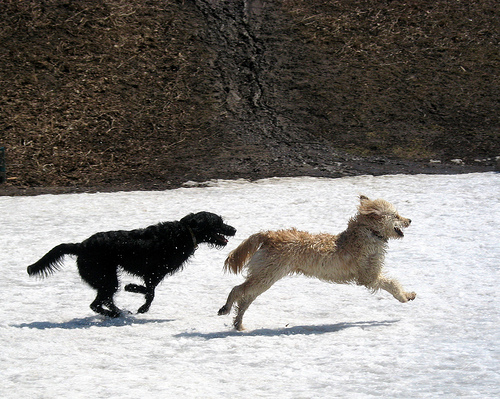

In [ ]:
for img_path, caps in train_raw.take(1):
    break
print(img_path)
img = load_img(img_path)
print(img.shape)
caps = [cap.numpy().decode('utf-8') for cap in caps]
print(caps)
Image.open(img_path.numpy().decode('utf-8'))

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self, img = img):
        self.image = img[tf.newaxis, ...]
        self.caps = caps

    def on_epoch_end(self, epochs = None, logs = None):
        all_bleu1, all_bleu2, all_bleu3, all_bleu4, all_meteor, all_fscore = [], [], [], [], [], []
        print('\n')
        for temp in (0, 0.5, 1):
          gen_text = self.model.generate_text(self.image, temperature=temp)
          print(f'\nTemperature = {temp}')
          print(f'Generated text: {gen_text}')
          print(f'BLEU-1: {bleu_1([gen_text], [self.caps]):.4f}')
          print(f'BLEU-2: {bleu_2([gen_text], [self.caps]):.4f}')
          print(f'BLEU-3: {bleu_3([gen_text], [self.caps]):.4f}')
          print(f'BLEU-4: {bleu_4([gen_text], [self.caps]):.4f}')
          all_bleu1.append(bleu_1([gen_text], [self.caps]))
          all_bleu2.append(bleu_2([gen_text], [self.caps]))
          all_bleu3.append(bleu_3([gen_text], [self.caps]))
          all_bleu4.append(bleu_4([gen_text], [self.caps]))
        print(f'\nAverage Scores on Train Set:')
        print(f'BLEU-1: {np.max(all_bleu1):.4f}')
        print(f'BLEU-2: {np.max(all_bleu2):.4f}')
        print(f'BLEU-3: {np.max(all_bleu3):.4f}')
        print(f'BLEU-4: {np.max(all_bleu4):.4f}')

## Compiling and Training the Model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
callbacks = [GenerateText(),
             tf.keras.callbacks.EarlyStopping(patience = 6, restore_best_weights = True)]

In [ ]:
captioner_model.compile(loss = masked_loss, optimizer = optimizer, metrics = [masked_accuracy])

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
hist = captioner_model.fit(
    train_ds.repeat(),
    steps_per_epoch = 100,
    validation_data = test_ds.repeat(),
    validation_steps = 20,
    epochs = 300,
    callbacks = callbacks
)

Epoch 1/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.1169 - masked_accuracy: 0.1681



/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Temperature = 0
Generated text: a dog is a dog
BLEU-1: 0.2077
BLEU-2: 0.1996
BLEU-3: 0.1840
BLEU-4: 0.1629

Temperature = 0.5
Generated text: a dog is dog
BLEU-1: 0.1353
BLEU-2: 0.1353
BLEU-3: 0.1257
BLEU-4: 0.1157

Temperature = 1
Generated text: a area and a woman baby shirt hat nicely
BLEU-1: 0.8250
BLEU-2: 0.5997
BLEU-3: 0.3087
BLEU-4: 0.1664

Average Scores on Train Set:
BLEU-1: 0.8250
BLEU-2: 0.5997
BLEU-3: 0.3087
BLEU-4: 0.1664
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 5.1155 - masked_accuracy: 0.1684 - val_loss: 4.6831 - val_masked_accuracy: 0.2344
Epoch 2/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.6895 - masked_accuracy: 0.2441


Temperature = 0
Generated text: a dog is in a dog
BLEU-1: 0.3270
BLEU-2: 0.3167
BLEU-3: 0.2890
BLEU-4: 0.2504

Temperature = 0.5
Generated text: a dog and a brown dog is sitting
BLEU-1: 0.8549
BLEU-2: 0.8106
BLEU-3: 0.7176
BLEU-4: 0.6174

Temperature = 1
Generated text: a splits long jumping in with a tread mohawk is in a street

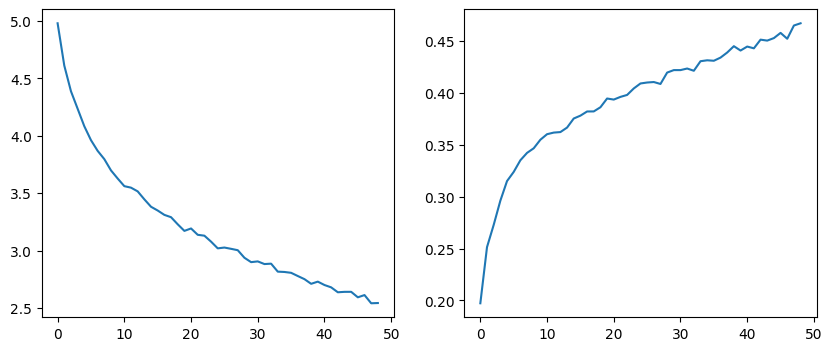

In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label = 'loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['masked_accuracy'], label = 'masked_accuracy')

plt.show()

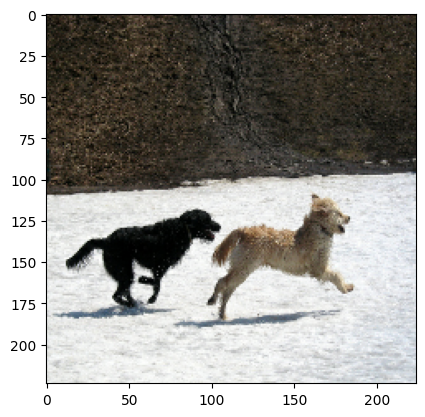

Generated Caption: a dog is running in the snow


In [ ]:
for img_path, caps in train_raw.batch(12).take(1):
    break

img = load_img(img_path[0].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

In [ ]:
image_list = []
reference_list = []

for img_path, caps in test_raw.take(100):
    img = load_img(img_path)
    img = tf.convert_to_tensor(img)
    img = feature_extractor(img[tf.newaxis, ...])[0]  # extract first item after batch

    captions = [cap.numpy().decode('utf-8') for cap in caps]

    image_list.append(img)
    reference_list.append(captions)

In [ ]:
def evaluate_model(model, image_list, reference_list):
    all_bleu1, all_bleu2, all_bleu3, all_bleu4 = [], [], [], []

    for img, refs in zip(image_list, reference_list):
        image = img[tf.newaxis, ...]
        bleu1_temps, bleu2_temps, bleu3_temps, bleu4_temps = [], [], [], []

        for temp in (0, 0.5, 1):
            gen_text = model.generate_text(image, temperature=temp)

            print(f'\nTemperature = {temp}')
            print(f'Generated text: {gen_text}')
            print(f'BLEU-1: {bleu_1([gen_text], [reference_list[0]]):.4f}')
            print(f'BLEU-2: {bleu_2([gen_text], [reference_list[0]]):.4f}')
            print(f'BLEU-3: {bleu_3([gen_text], [reference_list[0]]):.4f}')
            print(f'BLEU-4: {bleu_4([gen_text], [reference_list[0]]):.4f}')

            bleu1_temps.append(bleu_1([gen_text], [reference_list[0]]))
            bleu2_temps.append(bleu_2([gen_text], [reference_list[0]]))
            bleu3_temps.append(bleu_3([gen_text], [reference_list[0]]))
            bleu4_temps.append(bleu_4([gen_text], [reference_list[0]]))

        # Store the best BLEU scores from this image for averaging
        all_bleu1.append(np.max(bleu1_temps))
        all_bleu2.append(np.max(bleu2_temps))
        all_bleu3.append(np.max(bleu3_temps))
        all_bleu4.append(np.max(bleu4_temps))

    print(f'\nAverage Scores on Test Set:')
    print(f'BLEU-1: {np.mean(all_bleu1):.4f}')
    print(f'BLEU-2: {np.mean(all_bleu2):.4f}')
    print(f'BLEU-3: {np.mean(all_bleu3):.4f}')
    print(f'BLEU-4: {np.mean(all_bleu4):.4f}')

In [ ]:
evaluate_model(captioner_model, image_list, reference_list)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_14' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



Temperature = 0
Generated text: a brown dog is running through the snow
BLEU-1: 0.8974
BLEU-2: 0.7529
BLEU-3: 0.6537
BLEU-4: 0.5722

Temperature = 0.5
Generated text: a dog is running through the snow
BLEU-1: 0.9091
BLEU-2: 0.7347
BLEU-3: 0.5965
BLEU-4: 0.4858

Temperature = 1
Generated text: two brown dogs are playing outside in the woods
BLEU-1: 0.8723
BLEU-2: 0.8147
BLEU-3: 0.7641
BLEU-4: 0.7219

Temperature = 0
Generated text: a dog is jumping into a pool
BLEU-1: 0.8571
BLEU-2: 0.6901
BLEU-3: 0.5077
BLEU-4: 0.3784

Temperature = 0.5
Generated text: a small dog is playing in a pool
BLEU-1: 0.8125
BLEU-2: 0.7240
BLEU-3: 0.6284
BLEU-4: 0.5519

Temperature = 1
Generated text: the dog jumps in the water
BLEU-1: 0.8512
BLEU-2: 0.7011
BLEU-3: 0.5849
BLEU-4: 0.5068

Temperature = 0
Generated text: a woman in a blue and blue shirt is playing with a yellow toy
BLEU-1: 0.7377
BLEU-2: 0.5971
BLEU-3: 0.4426
BLEU-4: 0.3287

Temperature = 0.5
Generated text: a woman s hair is playing with a yell

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Temperature = 1
Generated text: a man is climbing a rope
BLEU-1: 0.7354
BLEU-2: 0.5039
BLEU-3: 0.3159
BLEU-4: 0.1893

Temperature = 0
Generated text: a man in a black jacket and white shirt is standing in a crowd of people
BLEU-1: 0.6389
BLEU-2: 0.4929
BLEU-3: 0.3597
BLEU-4: 0.2503

Temperature = 0.5
Generated text: a man in a black hat holding a man in a crowd
BLEU-1: 0.7333
BLEU-2: 0.5164
BLEU-3: 0.3711
BLEU-4: 0.2440

Temperature = 1
Generated text: a person in black and white jacket is few a surfer on a guy in a black and life jacket
BLEU-1: 0.5814
BLEU-2: 0.4052
BLEU-3: 0.2636
BLEU-4: 0.1588

Temperature = 0
Generated text: a crowd of people are playing football
BLEU-1: 0.8421
BLEU-2: 0.7076
BLEU-3: 0.5828
BLEU-4: 0.4730

Temperature = 0.5
Generated text: a crowd of people are wearing red and white jersey and white uniform
BLEU-1: 0.7059
BLEU-2: 0.4814
BLEU-3: 0.3198
BLEU-4: 0.2100

Temperature = 1
Generated text: a man is a spectators as they in red players all of the team after

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Temperature = 0
Generated text: a man is doing a trick on a skateboard
BLEU-1: 0.7632
BLEU-2: 0.5921
BLEU-3: 0.3918
BLEU-4: 0.2404

Temperature = 0.5
Generated text: a man is jumping over a skateboard with a white shirt on his skateboard
BLEU-1: 0.5915
BLEU-2: 0.3900
BLEU-3: 0.2525
BLEU-4: 0.1460

Temperature = 1
Generated text: a person is standing while running across the station walking along a track
BLEU-1: 0.6267
BLEU-2: 0.4413
BLEU-3: 0.2921
BLEU-4: 0.1911

Temperature = 0
Generated text: a man is riding a bicycle in a park
BLEU-1: 0.7219
BLEU-2: 0.5923
BLEU-3: 0.4202
BLEU-4: 0.3061

Temperature = 0.5
Generated text: a man and a woman are walking along a dirt path
BLEU-1: 0.7447
BLEU-2: 0.5398
BLEU-3: 0.3424
BLEU-4: 0.2269

Temperature = 1
Generated text: a group of people stand in a lake with a tennis ball in the background
BLEU-1: 0.7000
BLEU-2: 0.5517
BLEU-3: 0.3912
BLEU-4: 0.2792

Temperature = 0
Generated text: a group of people are standing in front of a large building
BLE

# Outputs

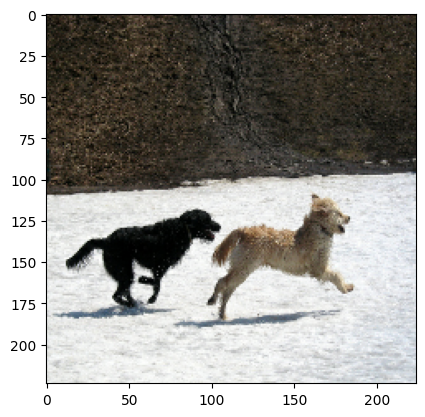

Generated Caption: two dogs play in the snow


In [ ]:
for img_path, caps in train_raw.batch(12).take(1):
    break

img = load_img(img_path[0].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

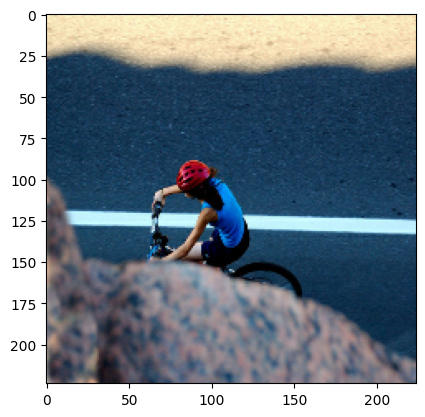

Generated Caption: a man wearing a red helmet is riding a bicycle


In [ ]:
img = load_img(img_path[5].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

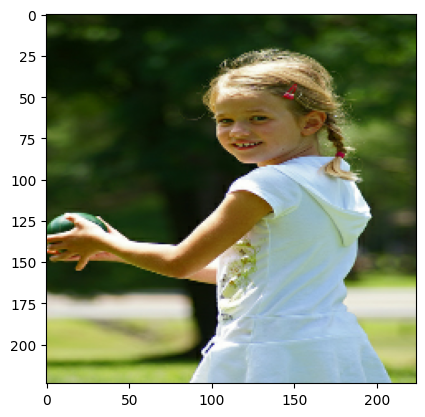

Generated Caption: a little girl in a white shirt is playing in the air


In [ ]:
img = load_img(img_path[8].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

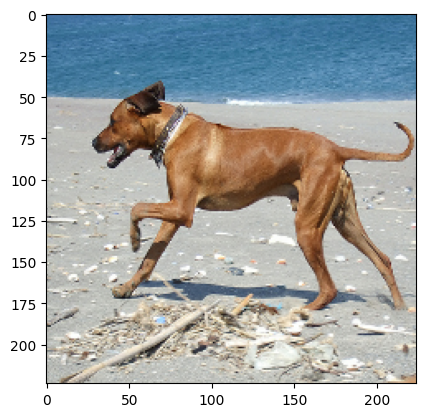

Generated Caption: a brown dog is running on a beach


In [ ]:
img = load_img(img_path[3].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

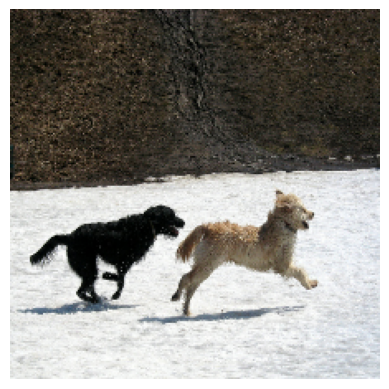

two dogs play in the snow


In [ ]:
for img_path, cap in train_raw.take(2):
    break
img = load_img(img_path)
cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])

plt.imshow(img/255)
plt.axis('off')
plt.show()
print(cap_gen)

In [ ]:
cap_gen_tokens = cap_gen.split() + ['[END]']
print(len(cap_gen_tokens))

7


In [ ]:
attn_scores = captioner_model.decoder.last_attention_scores
print(attn_scores.shape)
attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')
print(attn_maps.shape)

(1, 2, 7, 49)
(7, 7, 7)


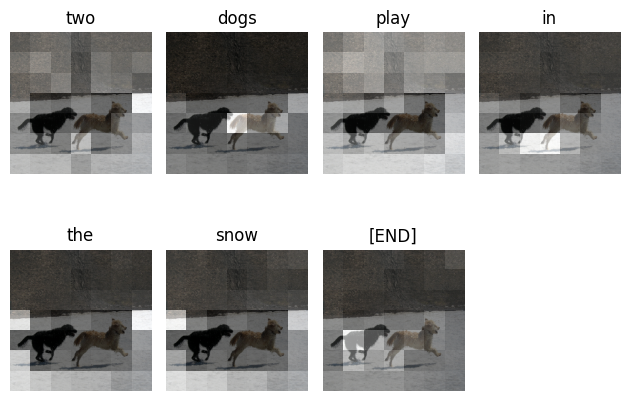

In [ ]:
len_result = len(attn_maps)
col_len = int(np.ceil(len_result/2))
row_len = 2

for i in range(len_result):
    ax = plt.subplot(row_len, col_len, i+1)
    img_plot = ax.imshow(img/255)
    plt.title(cap_gen_tokens[i])
    ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
@Captioner.add_method
def show_attention(self, img, temperature = 0.5):
    gen_text = self.generate_text(img = img[tf.newaxis, ...], temperature = temperature)
    cap_gen_tokens = gen_text.split() + ['[END]'] # Use gen_text instead of cap_gen
    # Here we are adding [END] token as while printing text using id_to_text, it filters out [END] token even though it is generated.
    attn_scores = captioner_model.decoder.last_attention_scores
    attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')

    len_result = len(attn_maps)
    col_len = int(np.ceil(len_result/2))
    row_len = 2

    for i in range(len_result):
        ax = plt.subplot(row_len, col_len, i+1)
        img_plot = ax.imshow(img/255)
        plt.title(cap_gen_tokens[i])
        ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
        plt.axis('off')

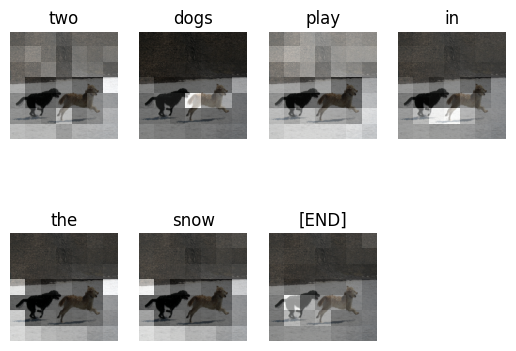

In [ ]:
captioner_model.show_attention(img)